In [ ]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
# Must install separately since Colab has torch 2.2.1, which breaks packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-u87077x8/unsloth_d39739f7e26341eebdff0347698d75c7
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-u87077x8/unsloth_d39739f7e26341eebdff0347698d75c7
  Resolved https://github.com/unslothai/unsloth.git to commit d215fd902cf28feb8abcfde2d25281d0fbf9d28c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 200 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Mistral patching release 2024.4
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias =  'lora_only',    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: bias = `none` is supported for fast patching. You are using bias = lora_only.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2024.4 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


                                                text  label  \
0  thi facebook post confus direct incom tax ever...      0   
1  we analyz theoret electron properti aharonov b...      0   
2  the possibl fli spacecraft close sun topic con...      1   
3  i think preclud possibl certain group peopl co...      0   
4  how studi test without cram studi test daunt e...      1   

                                              prompt   source    model  \
0  i ask question for question provid 200 word an...   reddit    human   
1  gener 150 220 word abstract work titl aharonov...    arxiv    human   
2  i ask question for question provid 200 word an...   reddit  chatGPT   
3  i ask question for question provid 200 word an...   reddit    human   
4  gener wikihow articl minimum 200 word titl how...  wikihow   cohere   

  dataset  pure  
0      M4     1  
1      M4     1  
2      M4     1  
3      M4     1  
4      M4     1  
14457


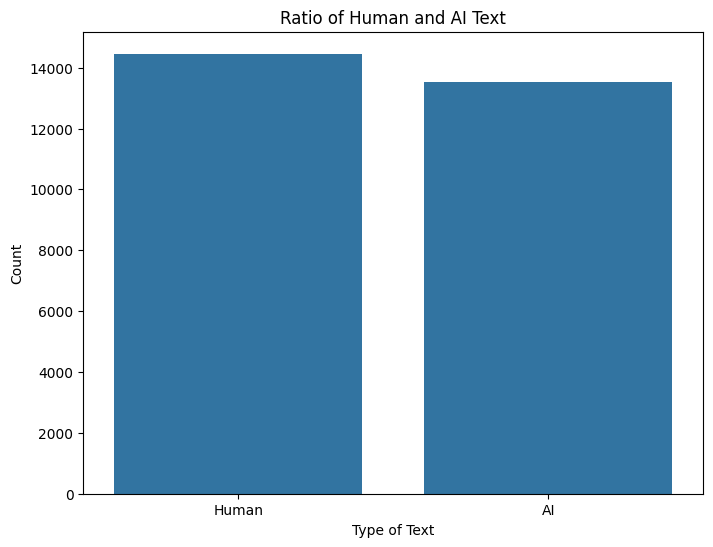

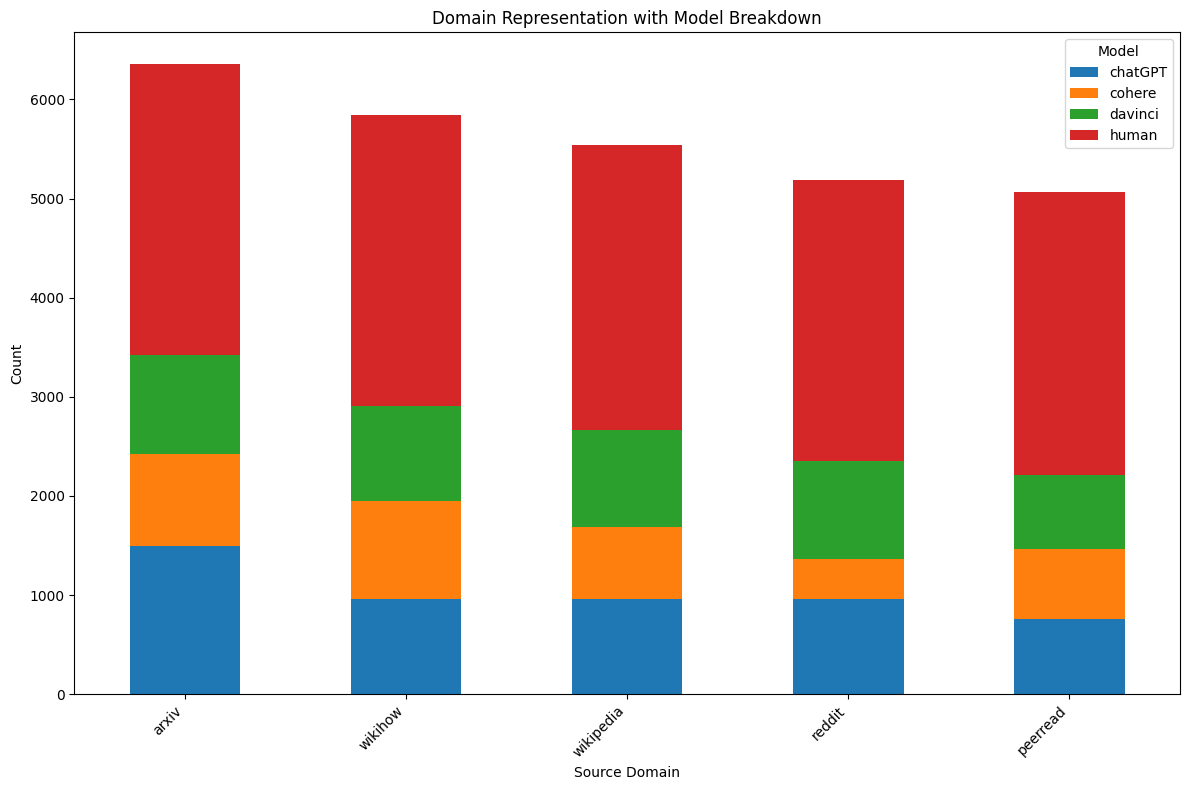

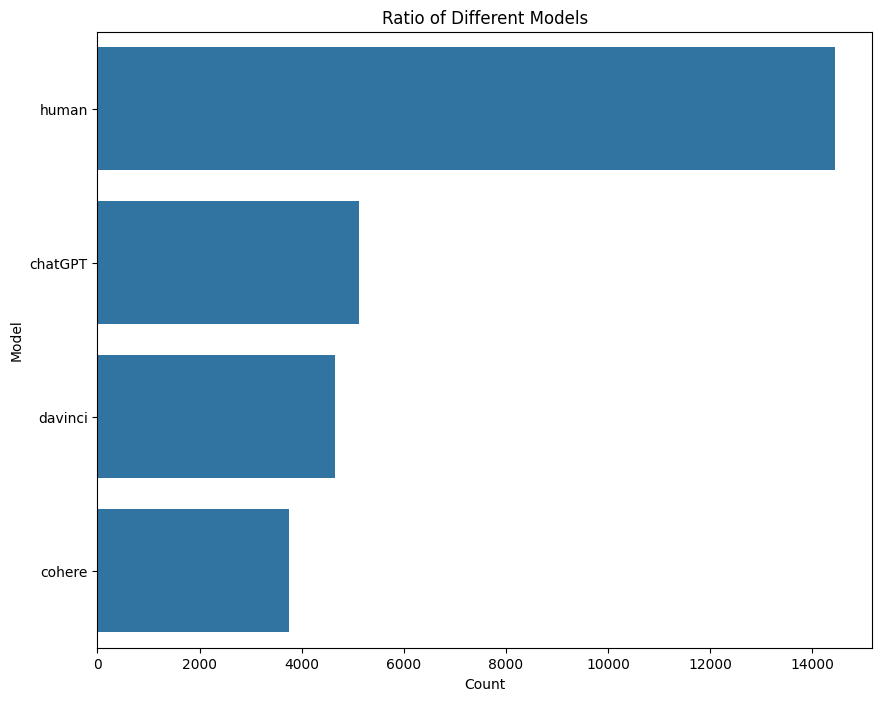

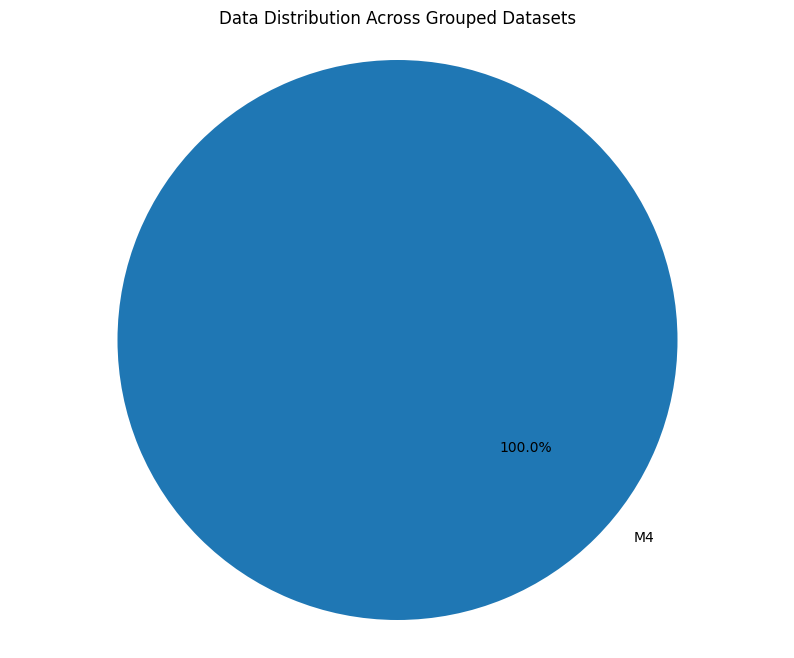

       source    model  count
0       arxiv  chatGPT   1495
1       arxiv   cohere    927
2       arxiv  davinci    995
3       arxiv    human   2942
4    peerread  chatGPT    756
5    peerread   cohere    710
6    peerread  davinci    743
7    peerread    human   2857
8      reddit  chatGPT    965
9      reddit   cohere    400
10     reddit  davinci    986
11     reddit    human   2841
12    wikihow  chatGPT    956
13    wikihow   cohere    990
14    wikihow  davinci    959
15    wikihow    human   2933
16  wikipedia  chatGPT    956
17  wikipedia   cohere    733
18  wikipedia  davinci    972
19  wikipedia    human   2884


In [ ]:
# Load the datasets
train = pd.read_csv('/content/train_balanced.csv')
val = pd.read_csv('/content/val_balanced.csv')
test = pd.read_csv('/content/test_balanced.csv')
test_MGTBench = pd.read_csv('/content/test_MGTBench.csv')
test_MixSet = pd.read_csv('/content/test_MixSet.csv')


# Remove rows where the 'text' column is NaN from train, val, and test datasets
train = train.dropna(subset=['text'])
val = val.dropna(subset=['text'])
test = test.dropna(subset=['text'])
test_MGTBench = test_MGTBench.dropna(subset=['text'])
test_MixSet = test_MixSet.dropna(subset=['text'])

# You may want to reset the index after dropping rows
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)
test_MGTBench = test_MGTBench.reset_index(drop=True)
test_MixSet = test_MixSet.reset_index(drop=True)

# Trying with smaller dataset for better controlling the training loss
train = train.head(15000)
val = val.head(10000)
test = test.head(3000)

# Combine the datasets for overall statistics
all_data = pd.concat([train, val, test], ignore_index=True)
print(all_data.head())
print(all_data[all_data['label'] == 0].shape[0])
# 1. Ratio of human and AI text
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=all_data)
plt.title('Ratio of Human and AI Text')
plt.xticks([0, 1], ['Human', 'AI'])
plt.xlabel('Type of Text')
plt.ylabel('Count')
plt.show()

# 2. Ratio of different domain sources
# Group the data by 'source' and 'model' and get the size of each group
model_domain_counts = all_data.groupby(['source', 'model']).size().unstack(fill_value=0)

# Calculate total counts for each domain by summing across models
total_counts_by_domain = model_domain_counts.sum(axis=1)

# Sort domains by total counts in descending order
sorted_domains = total_counts_by_domain.sort_values(ascending=False).index

# Reindex the DataFrame to reflect this order
model_domain_counts_sorted = model_domain_counts.reindex(sorted_domains)

# Now plot the sorted DataFrame
model_domain_counts_sorted.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Domain Representation with Model Breakdown')
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate domain names for better readability
plt.legend(title='Model')

plt.tight_layout()  # Adjust layout to make room for the rotated domain names
plt.show()

# 3. Ratio of different models
plt.figure(figsize=(10, 8))
sns.countplot(y='model', data=all_data, order = all_data['model'].value_counts().index)
plt.title('Ratio of Different Models')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

# 4. Show the dataset distribution
# Preprocess 'dataset' column to group all "Mixset" related data under a single category "Mixset"
all_data['dataset_grouped'] = all_data['dataset'].apply(lambda x: 'Mixset' if 'Mixset' in x else x)

# Aggregate data by the newly created 'dataset_grouped'
dataset_distribution_grouped = all_data['dataset_grouped'].value_counts()

# Plot pie chart for the grouped dataset distribution
plt.figure(figsize=(10, 8))
plt.pie(dataset_distribution_grouped, labels=dataset_distribution_grouped.index, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution Across Grouped Datasets')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

# Print the number of entries for each model within each domain
model_domain_counts = all_data.groupby(['source', 'model']).size().reset_index(name='count')
print(model_domain_counts)

In [ ]:
from datasets import Dataset

alpaca_prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(row):
    instruction = "Based on the following text, please determine if the text is written by a human or an AI."
    input_text = row['text']  # Assuming 'text' is the column with text to classify
    output_label = "Human" if row['label'] == 0 else "AI"

    # Format the text according to the Alpaca-style prompt
    formatted_text = alpaca_prompt.format(instruction, input_text, output_label) + EOS_TOKEN
    return formatted_text

# Apply the formatting function to your datasets
train['formatted_text'] = train.apply(formatting_prompts_func, axis=1)
val['formatted_text'] = val.apply(formatting_prompts_func, axis=1)
test['formatted_text'] = test.apply(formatting_prompts_func, axis=1)
test_MGTBench['formatted_text'] = test_MGTBench.apply(formatting_prompts_func, axis=1)
test_MixSet['formatted_text'] = test_MixSet.apply(formatting_prompts_func, axis=1)

# Prepare datasets for training and evaluation
train_data = Dataset.from_pandas(train[['formatted_text']])
val_data = Dataset.from_pandas(val[['formatted_text']])


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_data,
    eval_dataset = val_data,
    dataset_text_field = "formatted_text",
    max_seq_length = max_seq_length,
    args = TrainingArguments(
        output_dir = "outputs",
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407
    ),
)


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
import gc
import torch

# Explicitly free up unused memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # GPU memory cache clearing
gc.collect()  # General RAM garbage collection

torch.cuda.empty_cache()  # GPU memory cache clearing
gc.collect()  # General RAM garbage collection
trainer_stats = trainer.train()


Step,Training Loss
1,1.967500
2,1.901600
3,1.813100
4,1.622600
5,1.647600
6,1.757100
7,1.607500
8,1.567700
9,1.763800
10,1.748800


KeyboardInterrupt: 

### Saving the weights

In [ ]:
model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

### Testing Method 2

In [ ]:
import pandas as pd
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score


In [ ]:
class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=512):
        # Convert DataFrame to a list of dictionary entries (each row becomes a dictionary)
        self.data = dataframe.to_dict(orient='records')
        #self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        item = self.data[idx]

        text = item['text']
        label = item['label']
        return {'text': text, 'label': label}

    def __len__(self):
        return len(self.data)
    def __len__(self):
        return len(self.data)

In [ ]:
import gc
import torch

import gc
import torch
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_model(test_dataset, model, tokenizer, dataset_name, max_new_tokens=8):
    print("Evaluating", dataset_name)

    FastLanguageModel.for_inference(model)  # Enable native faster inference

    predictions = []
    references = []
    count = 0
    for item in tqdm(test_dataset):
        prompt = alpaca_prompt.format(
            "Based on the following text, please determine if the text is written by a human or an AI.",  # Instruction
            item['text'],  # Input text
            ""  # Output - leave this blank for generation
        )
        inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, use_cache=True)

        decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Because it also include the original prompt, we need to extract only the response part
        decoded_output = decoded_output.lower().split('### response:')[-1].strip().lower()
        #print("Decoded output ", decoded_output)

        # Notice that the output may not be single word only (e.g. I think it is human written -> human)
        if "human" in decoded_output.lower():
            generated_label = "human"
        elif "ai" in decoded_output.lower():
            generated_label = "ai"
        else:
            generated_label = "ai"

        #print("Generated_label = ", generated_label)

        predictions.append("Human" if generated_label == "human" else "AI")
        references.append(item['label'])

    # Convert labels to numeric
    predictions_numeric = [0 if pred == "Human" else 1 for pred in predictions]
    references_numeric = [0 if ref == "Human" else 1 for ref in references]

    # Explicitly free up unused memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # GPU memory cache clearing
    gc.collect()  # General RAM garbage collection
    return predictions_numeric, references_numeric

def plot_results(metrics, title, filename):
    plt.figure(figsize=(10, 5))
    categories = list(metrics.keys())
    values = list(metrics.values())
    plt.bar(categories, values, color='skyblue')
    plt.xlabel('Metric')
    plt.ylabel('Values')
    plt.title(title)
    plt.ylim(0, 1)
    plt.savefig(filename)
    plt.close()
    print(f"Plot saved as {filename}")

def calculate_metrics(predictions, references, dataset_name):
    accuracy = accuracy_score(references, predictions)
    f1 = f1_score(references, predictions)
    precision = precision_score(references, predictions)
    recall = recall_score(references, predictions)
    auc = roc_auc_score(references, predictions)
    cm = confusion_matrix(references, predictions)
    fp = cm[0][1]

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'AUC: {auc:.4f}')
    print(f'False Positives: {fp}')

    # Optional: Save the results to a JSON file
    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    }

    print("Results: ", results)

    results_path = f"./{dataset_name}_evaluation_results.json"
    with open(results_path, 'w') as fp:
        json.dump(results, fp, indent=4)

    print("Results saved to", results_path)
    plot_results(results, dataset_name, f"{dataset_name}_results.png")

# Function to calculate accuracy over different domains and models
def calculate_accuracy_by_group_Mixset(test_data, predictions, dataset_name):
    test_data['predictions'] = predictions

    filtered_test_data = test_data[test_data['model'] == 'GPT4']
    dataset_accuracy = filtered_test_data.groupby('dataset').apply(lambda group: accuracy_score(group['label'], group['predictions']))
    domain_accuracy = test_data.groupby('source').apply(lambda group: accuracy_score(group['label'], group['predictions']))
    model_accuracy = test_data.groupby('model').apply(lambda group: accuracy_score(group['label'], group['predictions']))

    print("Accuracy by Domain:")
    print(domain_accuracy)
    print("\nAccuracy by Model:")
    print(model_accuracy)
    print("Accuracy by Dataset:")
    print(dataset_accuracy)

    # Consolidate all results in one dictionary
    results = {
        "domain_accuracy": domain_accuracy.to_dict(),
        "model_accuracy": model_accuracy.to_dict(),
        "dataset_accuracy": dataset_accuracy.to_dict()
    }

    # Save the consolidated results to a JSON file
    results_path = f"./{dataset_name}_accuracies.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Plotting the results
    plot_grouped_accuracies(domain_accuracy, f"{dataset_name} Domain Accuracies", f"{dataset_name}_domain_accuracies.png")
    plot_grouped_accuracies(model_accuracy, f"{dataset_name} Model Accuracies", f"{dataset_name}_model_accuracies.png")

# Function to calculate accuracy over different domains and models
def calculate_accuracy_by_group(test_data, predictions, dataset_name):
    test_data['predictions'] = predictions
    domain_accuracy = test_data.groupby('source').apply(lambda group: accuracy_score(group['label'], group['predictions']))
    model_accuracy = test_data.groupby('model').apply(lambda group: accuracy_score(group['label'], group['predictions']))

    print("Accuracy by Domain:")
    print(domain_accuracy)
    print("\nAccuracy by Model:")
    print(model_accuracy)

    # Consolidate all results in one dictionary
    results = {
        "domain_accuracy": domain_accuracy.to_dict(),
        "model_accuracy": model_accuracy.to_dict()
    }

    # Save the consolidated results to a JSON file
    results_path = f"./{dataset_name}_accuracies.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Plotting the results
    plot_grouped_accuracies(domain_accuracy, f"{dataset_name} Domain Accuracies", f"{dataset_name}_domain_accuracies.png")
    plot_grouped_accuracies(model_accuracy, f"{dataset_name} Model Accuracies", f"{dataset_name}_model_accuracies.png")


def plot_grouped_accuracies(accuracy_data, title, filename):
    """ Function to plot and save grouped accuracies such as domain or model specific accuracies. """
    plt.figure(figsize=(10, 5))
    plt.bar(accuracy_data.index, accuracy_data.values, color='skyblue')
    plt.xlabel('Groups')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Plot saved as {filename}")

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # GPU memory cache clearing
gc.collect()  # General RAM garbage collection

114

## Debugging

In [ ]:
alpaca_prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""
EOS_TOKEN = tokenizer.eos_token

test_MixSet = pd.read_csv('/content/test_MixSet.csv').dropna(subset=['text']).reset_index(drop=True)
test_MixSet = test_MixSet.head(10)
test_MixSet_Dataset = TextDataset(test_MixSet)
predictions_numeric, references_numeric = evaluate_model(test_MixSet_Dataset, model, tokenizer, "test")
calculate_metrics(predictions_numeric, test_MixSet['label'].astype(int).values, "test")
calculate_accuracy_by_group_Mixset(test_MixSet, predictions_numeric, "test")

Evaluating test


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Accuracy: 0.9000
F1 Score: 0.9333
Precision: 0.8750
Recall: 1.0000
AUC: 0.8333
False Positives: 1
Results:  {'accuracy': 0.9, 'precision': 0.875, 'recall': 1.0, 'f1_score': 0.9333333333333333, 'auc': 0.8333333333333334}
Results saved to ./test_evaluation_results.json
Plot saved as test_results.png
Accuracy by Domain:
source
QA        1.0
blog      1.0
news      1.0
speech    0.5
dtype: float64

Accuracy by Model:
model
GPT4     1.000000
human    0.666667
other    1.000000
dtype: float64
Accuracy by Dataset:
dataset
MixsetHUMANIZE           1.0
MixsetPOLISH_SENTENCE    1.0
MixsetREWRITE            1.0
dtype: float64
Plot saved as test_domain_accuracies.png
Plot saved as test_model_accuracies.png


## Testing Phrase

In [ ]:
import gc
import torch

torch.cuda.empty_cache()  # Attempt to free up unused memory

# Load and preprocess the test data
test = pd.read_csv('/content/test_balanced.csv').dropna(subset=['text']).reset_index(drop=True)
test_Dataset = TextDataset(test)
test_MGTBench = pd.read_csv('/content/test_MGTBench.csv').dropna(subset=['text']).reset_index(drop=True)
test_MGTBench_Dataset = TextDataset(test_MGTBench)
test_MixSet = pd.read_csv('/content/test_MixSet.csv').dropna(subset=['text']).reset_index(drop=True)
#test_MixSet = test_MixSet.head(10)
test_MixSet_Dataset = TextDataset(test_MixSet)

predictions_numeric, references_numeric = evaluate_model(test_Dataset, model, tokenizer, "test")
calculate_metrics(predictions_numeric, test['label'].astype(int).values, "test")
calculate_accuracy_by_group(test, predictions_numeric, "test")

predictions_numeric, references_numeric = evaluate_model(test_MGTBench_Dataset, model, tokenizer, "MGTBench")
calculate_metrics(predictions_numeric, test_MGTBench['label'].astype(int).values, "MGTBench")
calculate_accuracy_by_group(test_MGTBench, predictions_numeric, "MGTBench")

predictions_numeric, references_numeric = evaluate_model(test_MixSet_Dataset, model, tokenizer, "MixSet")
calculate_metrics(predictions_numeric, test_MixSet['label'].astype(int).values, "MixSet")
calculate_accuracy_by_group_Mixset(test_MixSet, predictions_numeric, "MixSet")


Evaluating test


Streaming output truncated to the last 5000 lines.
100%|██████████| 17477/17477 [1:05:16<00:00,  4.46it/s]


Accuracy: 0.6747
F1 Score: 0.7429
Precision: 0.6044
Recall: 0.9636
AUC: 0.6816
False Positives: 5376
Results:  {'accuracy': 0.6746581221033359, 'precision': 0.6044150110375276, 'recall': 0.9636320976067574, 'f1_score': 0.7428778149588495, 'auc': 0.6815814905547469}
Results saved to ./test_evaluation_results.json
Plot saved as test_results.png
Accuracy by Domain:
source
arxiv        0.557076
peerread     0.917241
reddit       0.792510
wikihow      0.612274
wikipedia    0.521765
dtype: float64

Accuracy by Model:
model
chatGPT    0.951204
cohere     0.949224
davinci    0.988791
human      0.399531
dtype: float64
Plot saved as test_domain_accuracies.png
Plot saved as test_model_accuracies.png
Evaluating MGTBench


串流輸出內容已截斷至最後 5000 行。
100%|██████████| 11965/11965 [41:32<00:00,  4.80it/s]


Accuracy: 0.5473
F1 Score: 0.6862
Precision: 0.5243
Recall: 0.9930
AUC: 0.5486
False Positives: 5374
Results:  {'accuracy': 0.5473464270789804, 'precision': 0.5242984863238028, 'recall': 0.9929589270746019, 'f1_score': 0.686247248291044, 'auc': 0.5486461302039676}
Results saved to ./MGTBench_evaluation_results.json
Plot saved as MGTBench_results.png
Accuracy by Domain:
source
essay    0.532193
news     0.581250
story    0.528453
dtype: float64

Accuracy by Model:
model
GPT4       0.988533
chatGPT    0.997333
human      0.104333
dtype: float64
Plot saved as MGTBench_domain_accuracies.png
Plot saved as MGTBench_model_accuracies.png
Evaluating MixSet


100%|██████████| 1530/1530 [05:15<00:00,  4.85it/s]


Accuracy: 0.7693
F1 Score: 0.8555
Precision: 0.7583
Recall: 0.9812
AUC: 0.6325
False Positives: 333
Results:  {'accuracy': 0.769281045751634, 'precision': 0.7583454281567489, 'recall': 0.9812206572769953, 'f1_score': 0.8555055259926321, 'auc': 0.6325458125094654}
Results saved to ./MixSet_evaluation_results.json
Plot saved as MixSet_results.png
Accuracy by Domain:
source
QA        0.995000
blog      0.826923
news      0.519608
speech    0.522436
dtype: float64

Accuracy by Model:
model
GPT4     0.977778
human    0.283871
other    0.990000
dtype: float64
Accuracy by Dataset:
dataset
MixsetCOMPLETE           0.987097
MixsetHUMANIZE           1.000000
MixsetPOLISH_SENTENCE    0.941935
MixsetREWRITE            0.961290
dtype: float64
Plot saved as MixSet_domain_accuracies.png
Plot saved as MixSet_model_accuracies.png
